In [1]:
import pandas as pd
import torch
from torch.utils.data import Dataset


# Create a CustomDataset class to represent the data
class StockDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        features_sample = self.features[idx]
        labels_sample = self.labels[idx]
        return features_sample, labels_sample



In [73]:
# Load the data from the CSV file into a DataFrame
data = pd.read_csv("../data/VCB.VN.csv")
data = data.dropna(axis=0)
# Convert the features and labels to NumPy arrays
features = data.iloc[:, 1:].to_numpy()
labels = data['Close'].to_numpy()
# normalize /1000
labels = labels / 1000

features = torch.tensor(features, dtype=torch.float32)
labels = torch.tensor(labels, dtype=torch.float32)


In [74]:
features

tensor([[   22898.1836,    22898.1836,    22898.1836,    22898.1836,
            22898.1836,   770543.0000],
        [   24043.0938,    24043.0938,    22707.3652,    23089.0020,
            23089.0020, 16372619.0000],
        [   22707.3652,    22898.1836,    21944.0938,    22134.9121,
            22134.9121,  3971498.0000],
        ...,
        [   85600.0000,    87000.0000,    85000.0000,    86100.0000,
            86100.0000,  1157400.0000],
        [   86100.0000,    86700.0000,    85800.0000,    86600.0000,
            86600.0000,  1256400.0000],
        [   86300.0000,    86700.0000,    85500.0000,    86700.0000,
            86700.0000,  1071700.0000]])

In [75]:
date = data['Date']
# date to timestamp int
import datetime
import time
date = [time.mktime(datetime.datetime.strptime(d, "%Y-%m-%d").timetuple()) for d in date]

# # date to tensor
date = torch.tensor(date, dtype=torch.float32)
date = date.unsqueeze(1)
labels = labels.unsqueeze(1)
all_dataset = StockDataset(date,labels)

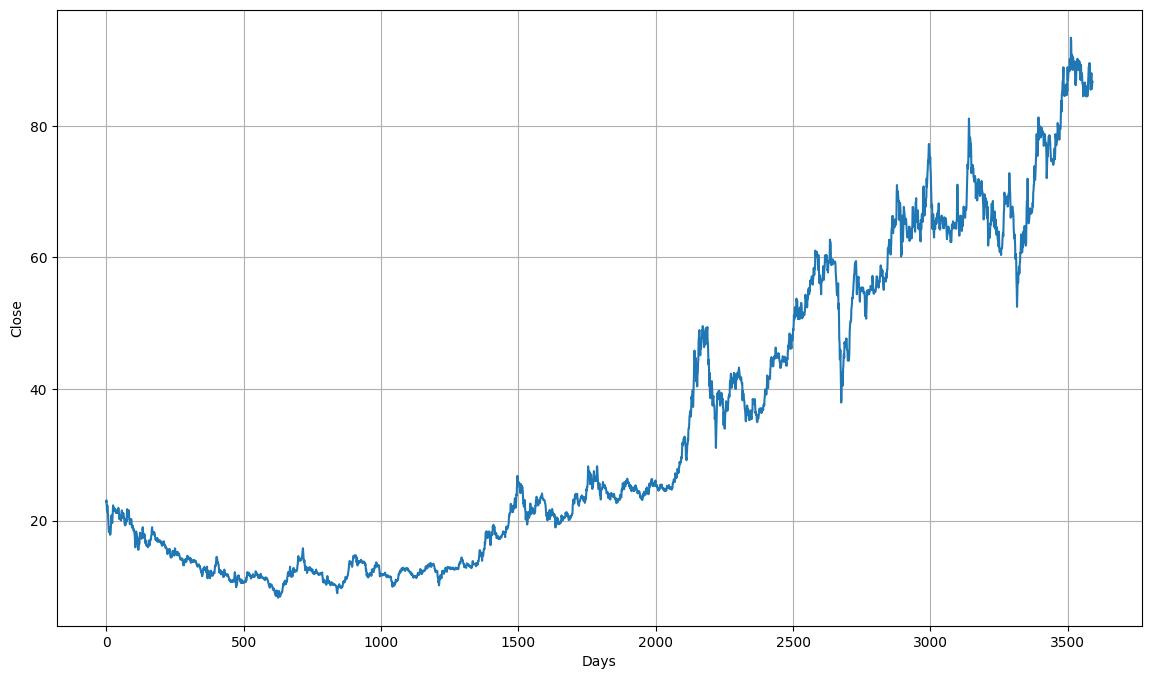

In [77]:
# plot stock data
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 8))
plt.plot(labels)
plt.xlabel('Days')
plt.ylabel('Close')
plt.grid(True)
plt.show()


In [7]:
import sys  
sys.path.append('..')


In [10]:
from src.configs.model_config import configs
print(configs)


<Axes: xlabel='sessionDate'>

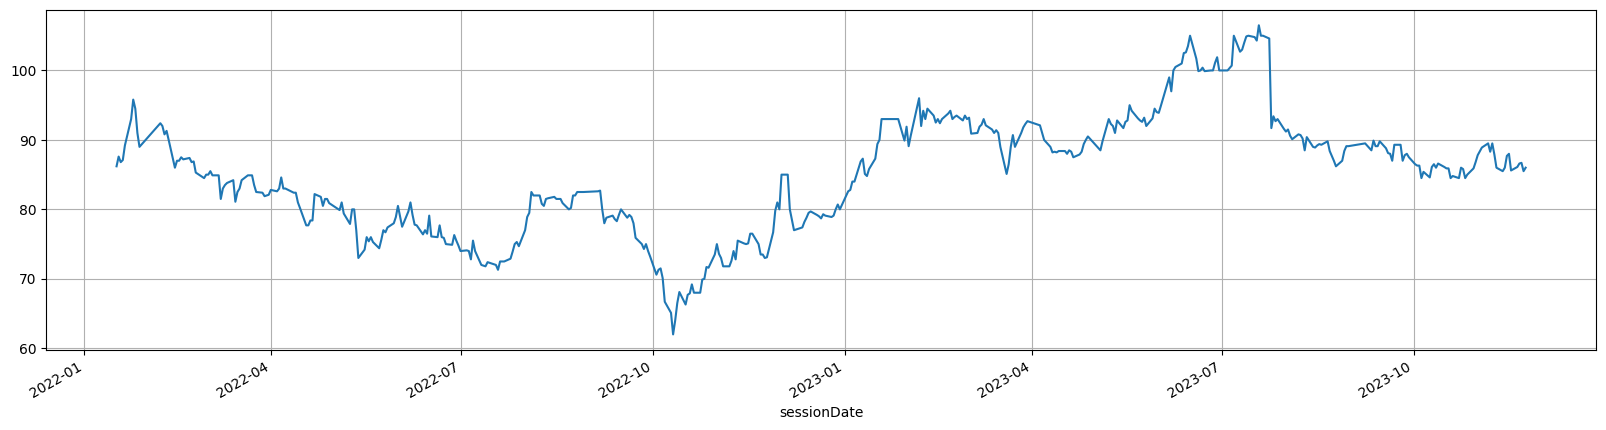

In [55]:
# import json
# with open(f'../data/VCB_price_histories.json') as f:
#     prices = json.load(f)
# price_histories = prices
# # price_histories to pandas dataframe and plot
# df = pd.DataFrame(price_histories)
# df['sessionDate'] = pd.to_datetime(df['sessionDate'])
# df.set_index('sessionDate', inplace=True)
# df['priceClose'].plot(figsize=(20,5), grid=True)

In [79]:
# features = df.index.to_numpy()
# # date to  timestamp pandas to number
# features = features.astype('datetime64[s]').astype('int')
# labels = df['priceClose'].to_numpy()
# features = torch.tensor(features, dtype=torch.float32).unsqueeze(1)
# labels = torch.tensor(labels, dtype=torch.float32).unsqueeze(1)
# all_dataset = StockDataset(features,labels)


C:\Users\nguyen\AppData\Local\Temp\ipykernel_31972\3581179697.py:3: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  features = features.astype('datetime64[s]').astype('int')


In [106]:
from torch.utils.data import DataLoader
from torch.utils.data import random_split




# split to train, val, test
total_size = len(all_dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    all_dataset, [train_size, val_size, test_size])


train_loader = DataLoader(
    train_dataset, batch_size=32, shuffle=True)

val_loader = DataLoader(
    val_dataset, batch_size=32, shuffle=False)

test_loader = DataLoader(
    test_dataset, batch_size=32, shuffle=False)


torch.Size([32, 1])
torch.Size([32, 1])


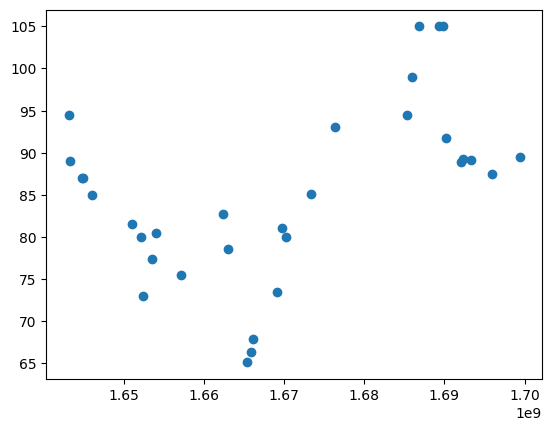

In [107]:
# plot train data
for features, labels in train_loader:
    print(features.shape)
    print(labels.shape)
    plt.plot(features, labels, 'o')
    plt.show()
    break

In [108]:
import torch
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=1, batch_first=True)
        self.linear = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        output, _ = self.lstm(x)
        output = self.linear(output)
        return output




In [109]:
from src.configs.model_config import ModelConfig
import torch
def train(dataloader, model, loss_fn, optimizer):
    config = ModelConfig().get_config()
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # X = X.unsqueeze(1)
        # y = y.unsqueeze(1)
     
        X, y = X.to(config.device), y.to(config.device)

        # Compute prediction error
        pred = model(X)
        pred = pred.view(-1, 1)

        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # if batch % config.log_interval == 0:
        #     loss, current = loss.item(), (batch + 1) * len(X)
        #     print(f"\rloss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    # return loss
    return loss

In [110]:


import torch
import torch.optim as optim
import torch.nn.functional as F

from src.configs.model_config import ModelConfig
# from src.utils.train import train
from src.utils.test import test
from src.utils.wandb import wandb
from src.utils.logs import logging
from src.utils.model import save_model


def main():

    config = ModelConfig().get_config()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = LSTMModel(1,64,1).to(device)
    # model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
    # model.load_state_dict(torch.load("results/ltsm/last.pth"))
    model.train()

    optimizer = optim.Adam(model.parameters(), lr=0.01)
    # log models config to wandb
    wandb.config.update(config)

    for epoch in range(1000):
        print(f"Epoch {epoch+1}\n-------------------------------")

        loss = train(train_loader, model=model, loss_fn=nn.MSELoss(),
                     optimizer=optimizer)
        test(val_loader, model=model, loss_fn=nn.MSELoss())
        # 3. Log metrics over time to visualize performance
        print(f"loss: {loss}")

        # save model
        save_model(model, "results/ltsm/last.pth")

        # 4. Log an artifact to W&B
        # wandb.log_artifact("model.pth")
        # model.train()
main()

Epoch 1
-------------------------------
Test Error: 
 Accuracy: 0.0%, Avg loss: 86.692574 

loss: 33.4561882019043
Epoch 2
-------------------------------
Test Error: 
 Accuracy: 0.0%, Avg loss: 86.609562 

loss: 31.175453186035156
Epoch 3
-------------------------------
Test Error: 
 Accuracy: 0.0%, Avg loss: 86.473980 

loss: 37.66813278198242
Epoch 4
-------------------------------
Test Error: 
 Accuracy: 0.0%, Avg loss: 86.216370 

loss: 66.8204574584961
Epoch 5
-------------------------------
Test Error: 
 Accuracy: 0.0%, Avg loss: 85.591717 

loss: 121.44855499267578
Epoch 6
-------------------------------
Test Error: 
 Accuracy: 0.0%, Avg loss: 84.956295 

loss: 97.85055541992188
Epoch 7
-------------------------------
Test Error: 
 Accuracy: 0.0%, Avg loss: 84.805443 

loss: 31.408382415771484
Epoch 8
-------------------------------
Test Error: 
 Accuracy: 0.0%, Avg loss: 86.766224 

loss: 34.76203155517578
Epoch 9
-------------------------------
Test Error: 
 Accuracy: 0.0%, A

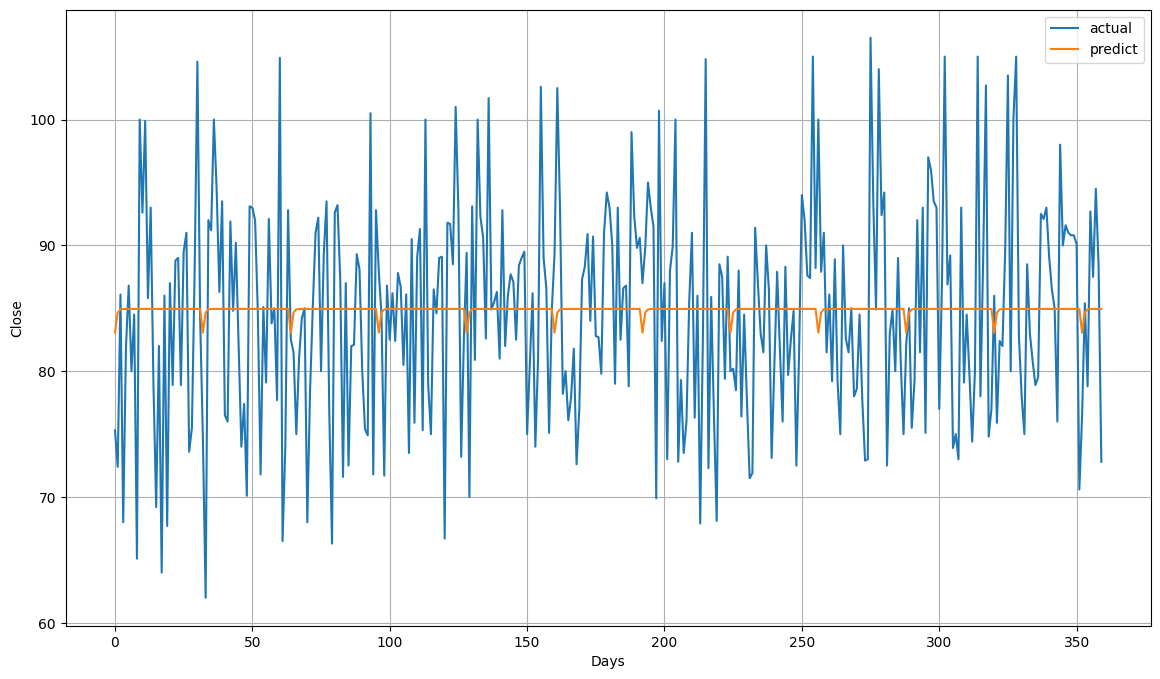

tensor(73.4641)


In [111]:
# load model and test
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = LinearRegressionModel().to(device)
# model.load_state_dict(torch.load("model.pth"))
model = LSTMModel(1,64,1).to(device)
model.load_state_dict(torch.load("results/ltsm/last.pth"))
model.eval()

actuals = []
preds = []
with torch.no_grad():
    for batch, (X, y) in enumerate(train_loader):
        # x = X.cpu().numpy()
        # print(x, X[-1], batch, len(X))
        X, y = X.to('cuda'), y.to('cuda')
        pred = model(X)
        preds.append(pred.cpu())
        actuals.append(y.cpu())
# plot

preds = torch.cat(preds)
actuals = torch.cat(actuals)

import matplotlib.pyplot as plt
plt.figure(figsize=(14, 8))
plt.plot(actuals, label='actual')
plt.plot(preds, label='predict')
plt.xlabel('Days')
plt.ylabel('Close')
plt.grid(True)
plt.legend()
plt.show()

# loss
import torch.nn.functional as F
loss = F.mse_loss(preds, actuals)
print(loss)
        
        




In [90]:
# today time stamp
import datetime
today = datetime.datetime.now()
today = today.timestamp()
# predict
today = torch.tensor(today, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
today = today.to('cuda')
pred = model(today)
print(pred)

tensor([[79.9237]], device='cuda:0', grad_fn=<AddmmBackward0>)
